Here we will compare many sets loaded from the same location and make compare them to the signature file. It will be mostly pinplots for multiple sets (test_your_set.py) and simulations for comparison with real sets (test_your_simulations.py). 

"""
Part 1. Compare multiple sets

As usual, import nesessary packages first
"""

In [1]:
import matplotlib.pyplot as plt, scipy.stats as ss, numpy as np

Load Aging List from file 
modify mdir line and f_in line according to your file name and location

In [2]:
"input file with precalculated signature gene list"
mdir="/Users/Art/Drive/PhD/Experiments/Aging Signature/000_FINAL/00_sourceFiles/"

use line below if you load META list

In [5]:
f_in=open(mdir+ "Aging_List_META.txt","r")

In [ ]:
or use the line below for the REANalysed list

In [3]:
f_in=open(mdir+ "01_Aging_List_REAN.txt","r")

In [4]:
lines=f_in.readlines()
f_in.close()

Lines contain all data from the file, extract gene names (names) and their citation frequencies (freqs), then sort from high to low. Logically, maximal value for freqs will be the first item from the list, therefore mymax=sort[0][0]

In [5]:
names, freqs=[],[]
for line in lines[1:]:
    items=line.rstrip().split("\t")
    names.append(items[0])
    freqs.append(int(items[1]))
print("names", len(names))
print("freqs", len(freqs))
sort=sorted(zip(freqs,names), reverse=True)
print(sort[:10],"...")
mymax=sort[0][0]
print("mymax",mymax)

names 5443
freqs 5443
[(12, 'Selp'), (11, 'Nupr1'), (11, 'Mt1'), (10, 'Plscr2'), (10, 'Clec1a'), (9, 'Itgb3'), (9, 'Gstm2'), (9, 'Enpp5'), (8, 'Zg16'), (8, 'Vwf')] ...
mymax 12


Extract list of names and citation scores

In [6]:
"Split sort list on gene names and gene scores"
GeneScore,Genes=[item[0] for item in sort],[item[1] for item in sort]

print("GeneScore", len(GeneScore), GeneScore[:20], "...") #a.k.a. rank score
print("Genes", len(Genes), Genes[:5])
print(max(GeneScore)) #should be the same as mymax

GeneScore 5443 [12, 11, 11, 10, 10, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8] ...
Genes 5443 ['Selp', 'Nupr1', 'Mt1', 'Plscr2', 'Clec1a']
12


Now we have to find the control points for the Enrichment Score calculation and for the graphic representation. These are the cumulative points of groups of genes divided by GeneScore value. 

In [7]:
print("make control points for DGSE plot")
control_points=[]
for i in range(0,len(GeneScore)-1):
    if GeneScore[i]!=GeneScore[i+1]:
        control_points.append(i+1)
        print(sort[i])
control_points.append(len(GeneScore)) #add last control point
print("Control points", control_points)
print("Control point 7", control_points[7])

make control points for DGSE plot
(12, 'Selp')
(11, 'Mt1')
(10, 'Clec1a')
(9, 'Enpp5')
(8, 'Alcam')
(7, 'Abca4')
(6, 'Adgrg2')
(5, 'Abat')
(4, '')
(3, 'A530040E14Rik')
(2, '4930438A08Rik')
Control points [1, 3, 5, 8, 23, 34, 60, 122, 222, 434, 1132, 5443]
Control point 7 122


There can be multiple ways how you count those control points. Here is another one (which you can use as alternative to above or skip)

In [8]:
points=[]
for i in range(1, mymax+1):
    points.append(GeneScore.count(i))
print("Gene groups by GeneScore value", points[::-1])
control_points=[]
for i in range(1,len(points)+1):
    control_points.append(sum(points[::-1][0:i]))
print("Cumulative control points", control_points)
    

Gene groups by GeneScore value [1, 2, 2, 3, 15, 11, 26, 62, 100, 212, 698, 4311]
Cumulative control points [1, 3, 5, 8, 23, 34, 60, 122, 222, 434, 1132, 5443]


Now we load multiple files with aging gene lists for further tests

In [9]:
mdir="/Users/Art/Drive/PhD/Experiments/Aging Signature/000_FINAL/00_sourceFiles/rean/"
"make shortlists from all signature files"
files=["Bersenev_GSE39553n_DE_YOn.csv","Chambers_GSE6503_YOn.csv",
    "Flach_GSE48893_YOn.csv","Grover_GSE70657_DE_OY.csv",
    "Kirshner_GSE87631_DE_OY.csv","Kowalczyk_GSE59114_DE_OY.csv",
    "Lazare_DE_YO.csv","Mann_GSE1004426_DE_OY.csv",
      "Maryanovich_GSE109546_DE_YO.csv","Norddahl_GSE27686_DE_YOn.csv",
      "Sun_GSE47817_DE_YO.csv","Wahlestedt_GSE44923_DE_YOn.csv"]
setnames=[]
for f in files:
    items=f.split("_") #(or you can split by ".")
    setnames.append(items[0])
print(setnames)

['Bersenev', 'Chambers', 'Flach', 'Grover', 'Kirshner', 'Kowalczyk', 'Lazare', 'Mann', 'Maryanovich', 'Norddahl', 'Sun', 'Wahlestedt']


The block below goes in one loop, therefore cannot be split

In [10]:
"run through all files and estimate scores"
print("file", "observed","expected","delta","enrichment%", "fisher","chisquare", sep="\t")
fis,chis,RScores,EnScores, deltas, set_len,shorts=[],[],[],[],[],[],[]#all fishers and chisquares series, rank scores and deltas
for file in files:
    f_in=open(mdir+ file,"r")
    lines=f_in.readlines()
    f_in.close()
    names=[]
    for line in lines[2:]:
        items=line.rstrip().replace(" ","").split("\t")
        item=items[1].split("///") #choose column with names
        names.append(item[0]) #use only the first out of many names
    shortlist,scores=[],[] #gene indexes and scores
    set_len.append(len(names))
    #calculate rank score
    for name in names:
        if name in Genes:
            shortlist.append(Genes.index(name))
            scores.append(GeneScore[Genes.index(name)])
          #  if file=="signature_list_max.csv":
           #     print("max score list", name, GeneScore[Genes.index(name)])
        else:
            scores.append(1) #unlisted genes go to the score 1
         #   if file=="signature_list_max.csv":
          #      print(name, " not in the list")
    #print("list lengthes", file, len(names), len(shortlist))
    "count rank score" #add all scores if >1, subtract all scores==1
    RankScore=0
    for s in scores:
        if s>1:
            RankScore+=s
        else:
            RankScore -=s
    RScores.append(RankScore) #needed for pin-plot
    "make cumulative curve"
    observed,expected,delta,fisher,chisquare=[],[],[],[],[]
    for i in control_points:
            found = [x for x in shortlist if x < i]
            observe = (len(found))
            observed.append(observe)
            expect = len(shortlist) * i / len(Genes)
            expected.append(expect)
            delta.append(observe - expect)
      #      f = ss.chisquare([observe, len(shortlist) - observe], f_exp=[expect, len(shortlist) - expect])
       #     chisquare.append(f[1])
            f = ss.fisher_exact([[expect, len(shortlist) - expect], [observe, len(shortlist) - observe]])
            fisher.append(f[1])
    shorts.append(shortlist)
    EnScores.append(delta[7]*100/len(names)) #Enrichment scores at 5%
    print(file, int(observed[7]),int(expected[7]),int(delta[7]),EnScores[-1],fisher[7])#,chisquare[7])
    fis.append(fisher)
    chis.append(chisquare)
    deltas.append(delta)


file	observed	expected	delta	enrichment%	fisher	chisquare
Bersenev_GSE39553n_DE_YOn.csv 90 7 82 25.031316286138992 4.0514571839147773e-22
Chambers_GSE6503_YOn.csv 65 46 18 0.9154612815030281 0.0828366101137419
Flach_GSE48893_YOn.csv 24 4 19 11.018257521699015 0.00010103852185873956
Grover_GSE70657_DE_OY.csv 28 2 25 26.041417296240006 1.2411468326515012e-07
Kirshner_GSE87631_DE_OY.csv 9 0 8 27.758589013411726 0.0019356033191389036
Kowalczyk_GSE59114_DE_OY.csv 44 6 37 13.935059601647016 7.739504789413861e-09
Lazare_DE_YO.csv 45 1 43 51.97545648329124 4.322395162566108e-16
Mann_GSE1004426_DE_OY.csv 34 1 32 47.75858901341172 1.0447637406150871e-11
Maryanovich_GSE109546_DE_YO.csv 104 24 79 7.213134467957177 9.859476487904165e-14
Norddahl_GSE27686_DE_YOn.csv 161 17 143 18.532782561798818 7.251002133897658e-34
Sun_GSE47817_DE_YO.csv 109 58 50 1.9157209737473433 7.503189336186417e-05
Wahlestedt_GSE44923_DE_YOn.csv 152 8 143 36.23960167163957 8.928402397851202e-43


Both scores can be printed out for each set

In [32]:
print("Sets, gene_size,  RankScore, EnScore")
for i in range(len(files)):
    print(setnames[i],set_len[i], RScores[i], EnScores[i])

Sets, gene_size,  RankScore, EnScore
Beerman 457 184 18.921933059735267
Chambers 3188 -97 6.574275404798401
Flach 913 377 18.636726188886048
Grover 60 189 60.982472811741104
Kirshner 62 146 61.573870661203465
Kowalczyk 77 224 59.83528666455496
Noda 168 393 60.86342519269348
Quere 204 203 27.84521790978032
Rossi 805 784 28.881023536378784
Sun 2634 686 14.319602652287804
Wahlestedt 409 1021 63.42338560717713


We can visualise Rank Scores for all sets as pin-plot (or other kind)

([], <a list of 0 Text yticklabel objects>)

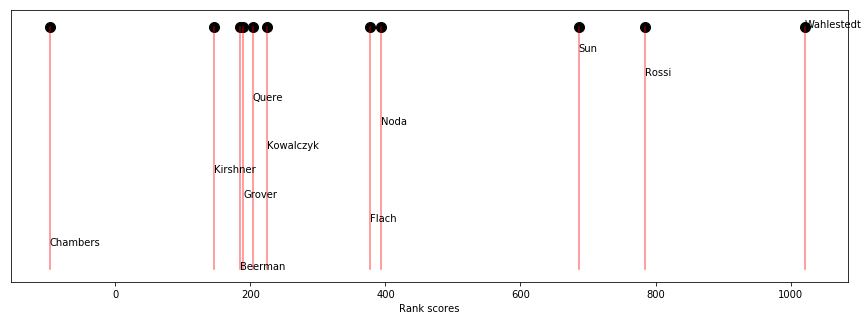

In [45]:
"make 1D pinplot for Rank scores"
data, scores,highs=fis,[],[]
scores=RScores
plt.figure(figsize=(15,5))
for i in range(len(scores)):
        height=5
        plt.plot([scores[i], scores[i]], [0, height], c="red", alpha=0.5)  # line
        plt.text(scores[i], i/2, setnames[i])  # text
        plt.scatter(scores[i], height, s=100, c="black", alpha=1)  # dot
plt.xlabel("Rank scores")
plt.yticks([],[])

Similarly, we draw pin-plot for Enrichment scores

([], <a list of 0 Text yticklabel objects>)

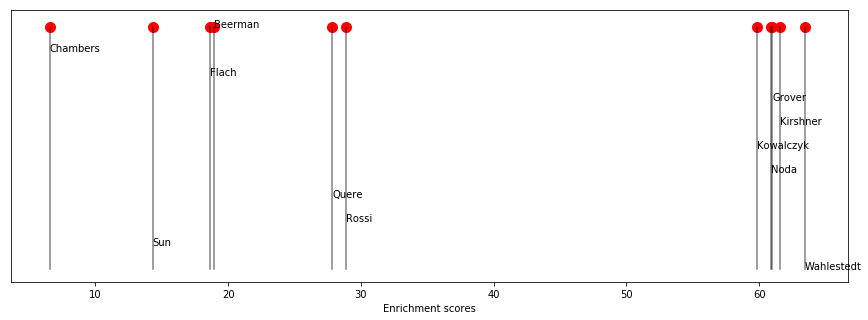

In [50]:
"pinplot for Enrichment scores"
data, scores,highs=fis,[],[]
scores=EnScores
plt.figure(figsize=(15,5))
for i in range(len(scores)):
        height = 10
        plt.plot([scores[i],scores[i]], [0,height],c="black", alpha=0.5) #line
        plt.text(scores[i],height-i,setnames[i]) #text
        plt.scatter(scores[i],height, s=100, c="red",alpha=1) #dot
plt.xlabel("Enrichment scores")
#figure can be saved by un-hashtag the line below
#plt.savefig(file[:-4]+".pdf")
plt.yticks([],[])

In [ ]:
Enrichment plot can be plotted for any of the sets, let say for the 4th set. 

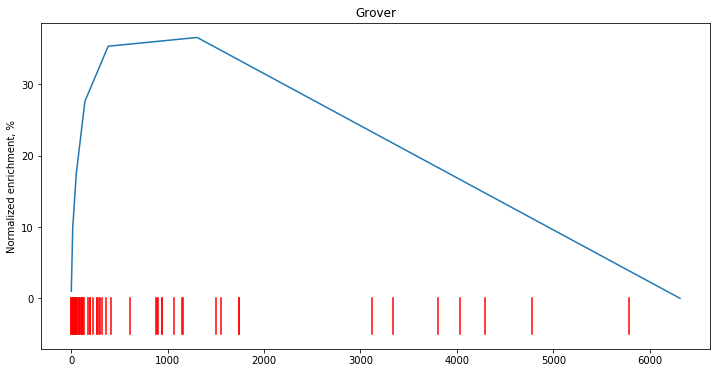

In [52]:
i=3 #the 4th set when counted from zero (this is how python counts)
plt.figure(figsize=(12,6))

"the dGSE plot"
plt.title(setnames[i])
plt.plot(control_points, deltas[i])
plt.ylabel("Normalized enrichment, %")
#red ticks
shortlist=shorts[i]
for i in range(len(shortlist)):
        x = [shortlist[i], shortlist[i]]
        y = [0, -5]
        plt.plot(x, y, c="red")

If you wonder what would be the Rank Score and Enrichment score for random subset of genes, look into another script, simulations.